In [74]:
import csv,fnmatch,os,json
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
from tqdm import tqdm

%matplotlib inline

data_folder = '/home/thebatou/Documents/Uni_Potsdam/Competitive_Data_Analysis/'
print 'Loading data ...'
data = pd.read_csv(os.path.join(data_folder, 'transformed_data.csv'), index_col=0)
print 'Done loading data! {} data were loaded.'.format(data.shape[0])

Loading data ...
Done loading data! 2177 data were loaded.


In [75]:
from sklearn.cross_validation import StratifiedKFold,cross_val_score
from sklearn.linear_model import SGDClassifier
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn import metrics

In [76]:
#data.columns
np.unique(data['status'])

array(['canceled', 'charged_off', 'current', 'defaulted', 'expired',
       'fully_paid', 'funded', 'in_funding', 'late_30', 'late_90'], dtype=object)

In [77]:
data.drop('loan_identifier',axis=1,inplace=True)
data.drop('borrower_identifier',axis=1,inplace=True)
data.drop('currency',axis=1,inplace=True)
data.drop('base_currency',axis=1,inplace=True)
data.drop('time_between_published_funded',axis=1,inplace=True)
data.drop('ratio_requested_funded',axis=1,inplace=True)
data.drop('amount_funded',axis=1,inplace=True)
data.drop('rates_paid',axis=1,inplace=True)
data.drop('rates_count',axis=1,inplace=True)
data.drop('prices',axis=1,inplace=True)
data.drop('portion_average_salary',axis=1,inplace=True)
data.drop('nominal_interest_rate',axis=1,inplace=True)

In [78]:
data = data.loc[data['status'].isin(['defaulted', 'fully_paid', 'late_90', 'charged_off'])]

In [79]:
y = data['status'] == 'fully_paid'

In [80]:
data.drop('status',axis=1,inplace=True)
X = data.as_matrix()

In [87]:
y = y.as_matrix()

Classification report for classifier DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best'):
             precision    recall  f1-score   support

      False       0.52      0.68      0.59        37
       True       0.78      0.65      0.71        66

avg / total       0.69      0.66      0.67       103


Confusion matrix:
[[25 12]
 [23 43]]
Classification report for classifier DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best'):
             precision    recall  f1-score   support

      False       0.51      0.83      0.63        36
       True       0.86

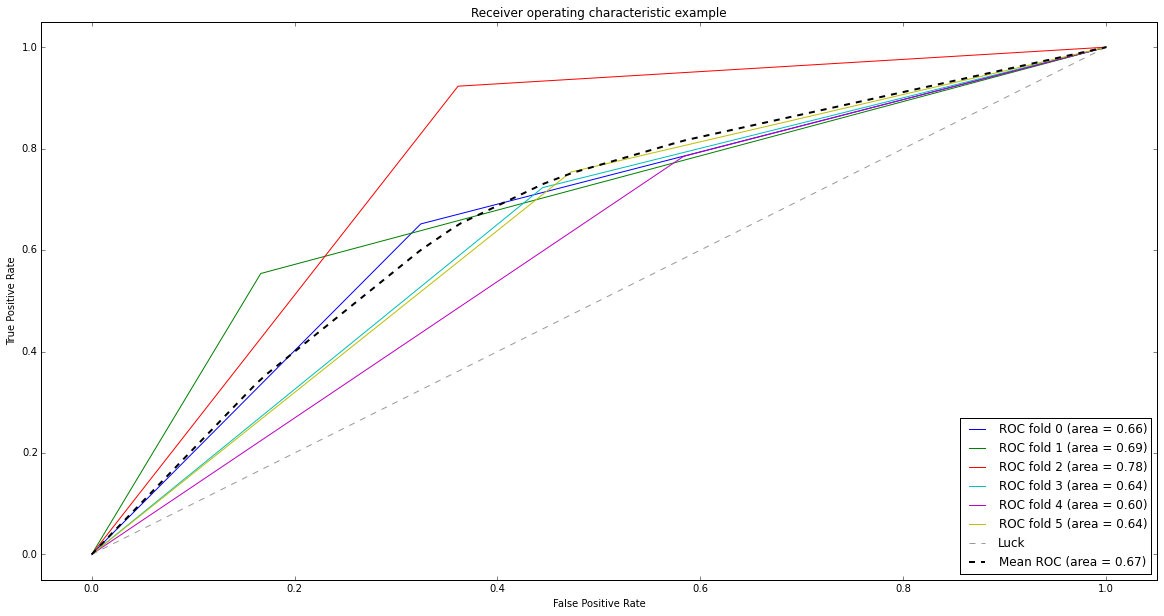

In [88]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score

#random_state = np.random.RandomState(0)

cv = StratifiedKFold(y, n_folds=6)
clf = DecisionTreeClassifier(random_state=0)
#clf = svm.SVC(probability=True)

cross_val_score(clf, X, y, cv=10)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
scores = []

plt.figure(figsize=(20,10))

for i, (train, test) in tqdm(enumerate(cv)):
    clf.fit(X[train], y[train])
    scores.append(clf.score(X[test], y[test]))
    y_scores = clf.predict(X[test]) #decision_function(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], y_scores)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    expected = y[test]
    predicted = clf.predict(X[test])

    print("Classification report for classifier %s:\n%s\n"
          % (clf, metrics.classification_report(expected, predicted)))
    print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [89]:
print clf.feature_importances_
print data.columns

[ 0.15346826  0.07615725  0.08785743  0.00179587  0.02185536  0.02973543
  0.01607169  0.10341377  0.02170985  0.00661637  0.06320575  0.
  0.16476317  0.14164576  0.11170403]
Index([u'term', u'purpose', u'borrower_rating', u'employment', u'region',
       u'facebook', u'twitter', u'paypal', u'ebay', u'linkedin', u'location',
       u'funded', u'address_lat', u'address_lng', u'net_income_cents'],
      dtype='object')


Feature ranking:
1. feature 0 (0.142721) 		 term
2. feature 1 (0.101493) 		 purpose
3. feature 13 (0.095063) 		 address_lng
4. feature 14 (0.093843) 		 net_income_cents
5. feature 12 (0.091160) 		 address_lat
6. feature 2 (0.089113) 		 borrower_rating
7. feature 4 (0.075724) 		 region
8. feature 10 (0.070830) 		 location
9. feature 7 (0.055690) 		 paypal
10. feature 8 (0.047920) 		 ebay
11. feature 3 (0.042021) 		 employment
12. feature 6 (0.038153) 		 twitter
13. feature 9 (0.031316) 		 linkedin
14. feature 5 (0.024956) 		 facebook
15. feature 11 (0.000000) 		 funded


/home/thebatou/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


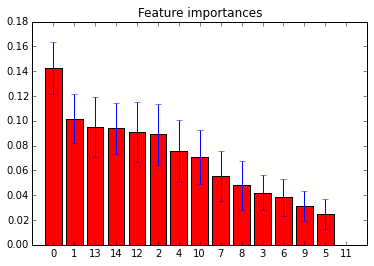

In [90]:
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f) \t\t %s" % (f + 1, indices[f], importances[indices[f]], data.columns[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV

X_train, y_train = X[:1300], y[:1300]
X_valid, y_valid = X[1300:1740], y[1300:1740]
X_train_valid, y_train_valid = X[:1740], y[:1740]
X_test, y_test = X[1740:], y[1740:]

# Train uncalibrated random forest classifier on whole train and validation
# data and evaluate on test data
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train_valid, y_train_valid)
clf_probs = clf.predict_proba(X_test)
score = log_loss(y_test, clf_probs)

# Train random forest classifier, calibrate on validation data and evaluate
# on test data
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train, y_train)
clf_probs = clf.predict_proba(X_test)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(X_valid, y_valid)
sig_clf_probs = sig_clf.predict_proba(X_test)
sig_score = log_loss(y_test, sig_clf_probs)


print("Log-loss of")
print(" * uncalibrated classifier trained on 1300 datapoints: %.3f "
      % score)
print(" * classifier trained on 1300 datapoints and calibrated on "
      "400 datapoint: %.3f" % sig_score)

ValueError: Found array with 0 sample(s) (shape=(0, 15)) while a minimum of 1 is required.